# Changepoint Detection Ensembles: Window search method

<!-- {{ add_binder_block(page) }} -->

## Introduction

Many changepoint detection (CPD) procedure can be implemented with `ruptures`. In most case, these procedures involve a search method relying on only one cost function. We are investigating here a way of building an ensemble model, on top of `ruptures` package, using the [window search method](../user-guide/detection/window.md) that will rely on several cost functions. The incentive is that this method takes the best of the methods that consider only one cost. 

The interested reader can refer to [Katser2021](#Katser2021) for a more complete introduction. As they do in the paper, we will make the assumption that the number of changepoints to detect is known in advance.

## Setup

First, we make the necessary imports and generate a toy signal. In order to highlight the strength of the ensemble model, we concatenate two kinds of signals. 

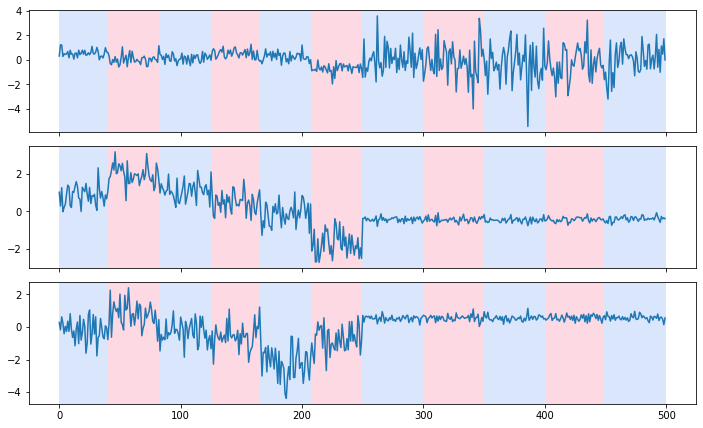

In [88]:
import time  # for execution time comparison

import matplotlib.pyplot as plt  # for display purposes
import numpy as np

import ruptures as rpt  # our package
from ruptures.metrics import randindex

# generate a signal
n_samples, dim, sigma = 250, 3, 4
n_bkps = 10 # number of breakpoints

# to make it more complex, we concatenate two different signals together
signal_constant, bkps_constant = rpt.pw_constant(n_samples=n_samples, n_features=dim, n_bkps=n_bkps // 2, noise_std=sigma, seed=1)
signal_linear, bkps_linear = rpt.pw_linear(n_samples=n_samples, n_features=dim - 1, n_bkps=n_bkps - n_bkps // 2 - 1, noise_std=sigma, seed=1)
signal = np.append(signal_constant, signal_linear, axis=0)
bkps = sorted(bkps_constant + list(np.array(bkps_linear) + n_samples))

# As it is done in the paper, we use the z-normalization
signal = (signal - signal.mean(axis=0)) / signal.std(axis=0)

fig, ax_array = rpt.display(signal, bkps)

## Window search method

In the following, we are going to use the cost functions:

- [Autoregressive model change](../user-guide/costs/costautoregressive.md) (ar)
- [Change detection with a Mahalanobis-type metric](../user-guide/costs/costml.md) (mahalanobis)
- [Least absolute deviation](../user-guide/costs/costl1.md) (l1)
- [Least squared deviation](../user-guide/costs/costl2.md) (l2)
- [Linear model change](../user-guide/costs/costlinear.md) (linear)

In [89]:
cost_functions = ["ar", "mahalanobis", "l1", "l2", "linear"]  # cost function that we will use
window_size = 20  # best hyperparameter according to the paper

### Classical method: one cost for one prediction

Let's start with the classical method: the window search method rely on only one cost function.

In [90]:
scores = []  # save the scores for the ensemble method (see next section)
rand_indexes = {}  # to keep track of the performances

for cost in cost_functions:
  start_time = time.time()

  algo = rpt.Window(width=window_size, model=cost, jump=1).fit(signal)
  predicted_bkps = algo.predict(n_bkps=n_bkps)
  
  print(f"{cost} cost computation in {time.time() - start_time:.3f} s")

  rand_indexes[cost] = np.around(randindex(bkps, predicted_bkps), 3)
  scores.append(algo.score)

ar cost computation in 0.117 s
mahalanobis cost computation in 0.040 s
l1 cost computation in 0.150 s
l2 cost computation in 0.072 s
linear cost computation in 0.084 s


Now that we have the performance of the classical method on each cost function, let's dive into the ensemble method. We will then compare the results.

### Ensemble method: multiple costs for one prediction

The paper we rely on [Katser2021](#Katser2021), uses the score from each cost function to detect the changepoints. This is why we stored them in the previous section.

Let's see how those scores look like. In the following cell, each row represents the score for a specific cost function.

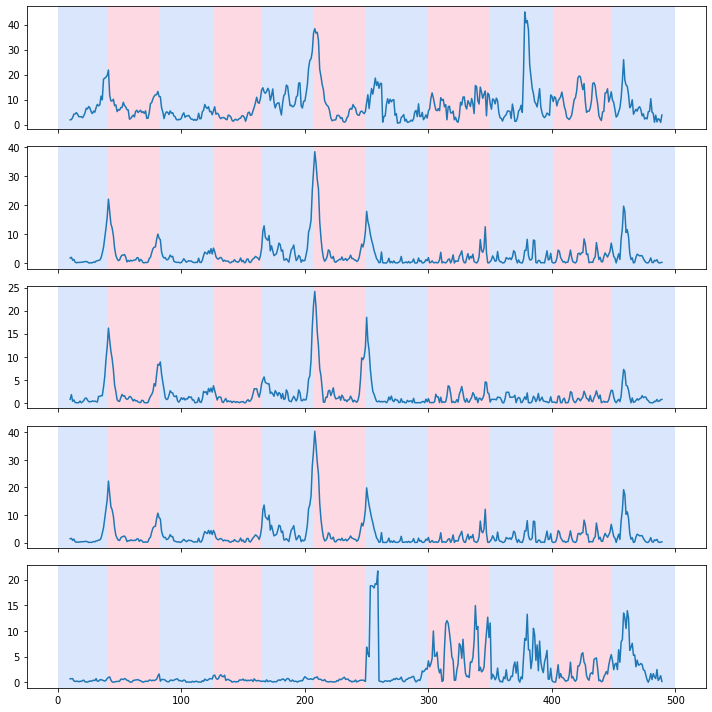

In [91]:
scores = np.array(scores).T

# Display the scores with the change points to predict
append_scores = np.append(np.ones((window_size // 2, len(cost_functions))) * float("inf"), scores, axis=0)
_ = rpt.display(append_scores, bkps)

The idea of the CPD Ensemble method is to scale and aggregate the scores with some well chosen scaling and aggregation function to get new score which will allow us to get a better prediction of the changepoints.

In the paper, they perform multiple tests on several scaling and aggregation functions on two datasets. In turned out that the *MinAbs* scaling function and the *WeightedSum* aggregation function worked the best.

The *MinAbs* function is defined as follows:
For $s$ a timeseries, $$ \textit{MinAbs}(s)_i = \frac{s_i}{|\min_{j}{s_j}|} $$

The *WeightedSum* function is defined as follows:
Let $s^n, n \in \{1, ..., N\}$ be $N$ timeseries, we have to distinguish the "original" timeseries $s^n$ from its scaled version $\overline{s}^n = \textit{MinAbs}(s^n)$. We then have

 $$ \textit{WeightedSum}((s_n)_{n \in \{1, ..., N\}})_i = \sum_{n \in \{1, ..., N\}}{\lambda_n \overline{s}_i^n} $$
 where $ \lambda_n = \frac{\max_{j}{s_j^n} - \min_{j}{s_j^n}}{\mu(s^n) - \min_{j}{s_j^n}} $ with $\mu(s^n)$ the mean of $s^n$.

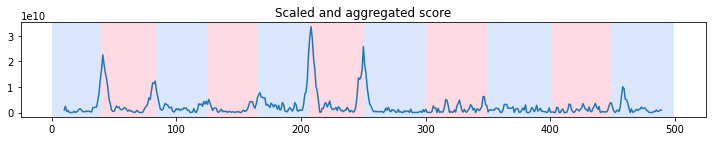

In [92]:
def min_abs_scaling(array):
    return array / abs(np.min(array, axis=0) + 1e-8)

def weighted_sum_aggregation(array):
    min_array = array.min(axis=0)
    weights = (array.max(axis=0) - min_array) / (array.mean(axis=0) - min_array)
    
    return min_abs_scaling(array) @ weights
    
aggregated_scores = weighted_sum_aggregation(scores)

# Display scaled and aggregated scores
append_scaled_aggregated_scores = np.append(np.ones(window_size // 2) * float("inf"), aggregated_scores)
rpt.display(append_scaled_aggregated_scores, bkps)
_ = plt.title("Scaled and aggregated score")

Let's now detect the changepoints from the newly computed score. For that we need to define a *DummyCost* that will allow us to leverage `ruptures` power.

In [93]:
from ruptures.base import BaseCost


class DummyCost(BaseCost):

    r"""
    Dummy cost to pretend a real cost function.
    """

    model = "Dummy"

    def __init__(self) -> None:
        """Initialize the object."""
        self.signal = None

    def fit(self, signal) -> "DummyCost":
        """Set parameters of the instance.
        Args:
            signal (array): signal. Shape (n_samples,) or (n_samples, n_features)
        Returns:
            self
        """
        if signal.ndim == 1:
            self.signal = signal.reshape(-1, 1)
        else:
            self.signal = signal

        return self

    def error(self, start, end) -> float:
        """Return the approximation cost on the segment [start:end].
        Args:
            start (int): start of the segment
            end (int): end of the segment
        Returns:
            + infinity
        """
        return float("inf")

Then we are using the window search method to predict the changepoints.

In [96]:
# create the ensemble change point detector
dummy_cost = DummyCost().fit(signal)
algo = rpt.Window(width=window_size, custom_cost=dummy_cost, jump=1)
algo.fit(signal)
algo.score = aggregated_scores

ensemble_predicted_bkps = algo.predict(n_bkps=n_bkps)
rand_indexes["ensemble"] = np.around(randindex(bkps, ensemble_predicted_bkps), 3)

_ = [print(cost, rand_index) for cost, rand_index in rand_indexes.items()]

ar 0.941
mahalanobis 0.941
l1 0.953
l2 0.941
linear 0.897
ensemble 0.953


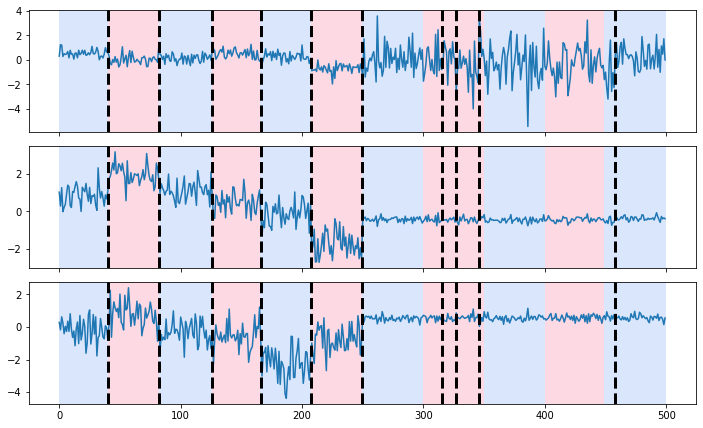

In [95]:
_ = rpt.display(signal, bkps, ensemble_predicted_bkps)

## Conclusion

Through this example, we have seen how to build an ensemble model to detect changepoints in a few lines of code.

This example is using a window search method, the algorithm for ensemble models using other search methods like Binary segmentation or Dynamic programming are given in the paper [Katser2021](#Katser2021).

## Authors

This example notebook has been authored by [Théo VINCENT](https://github.com/theovincent).


### References

<a id="Katser2021">[Katser2021]</a>
Katser, I., Kozitsin, V., Lobachev, V., & Maksimov, I. (2021). Unsupervised Offline Changepoint Detection Ensembles. Applied Sciences, 11(9), 4280.